## Algemene informatie
In dit notebook willen we jullie de basistechnieken van data-analyze en-visualisatie laten zien met behulp van Python 3.<br>
We doen dit aan de hand van een voorbeeld dataset die we genereren op basis van een simpel gedempte slingermodel.<br>
<br>
Voor de analyse gebruiken we verschillende packages van Python, deze laden we in met de volgende codes:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# import lmfit
import matplotlib.gridspec as gridspec

np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display.

## Voorbeeld 1: Gedempte harmonische trilling (slinger)
In deze sectie ga ik een proef dataset genereren voor een gedempte harmonische trilling. Dit kan bijvoorbeeld een realistische fysische slinger voorstellen. De dataset bestaat uit een y-coordinaat (dit kan bijvoorbeeld de x-beweging zijn) en een x-coordinaat, de tijd. 
De tijd-coordinaat is een <em>array</em> (een <em>lijst</em> die wiskundige operaties kan verwerken) die loopt van 0 tot 10 (seconde) met tijdstapjes van $\Delta t = 0.2$ (seconde). De eenheid is in principe arbitrair, maar je kunt het ook in seconden voor jezelf nemen.
<br>
De y-data (x-positie) genereren we met de volgende functie: <br>

 * $x(t) = e^{-0.2t}\sin(3t)+0.05t\zeta(t)$.

 Hierbij is het harmonische signaal gegeven door $\sin(\omega t)$ met $\omega$ = 3 $t^{-1}$. De demping is gemodelleerd met een exponentiele afname $e^{\gamma t}$, met $\gamma = 0.2$ $t^{-1}$ de dempingsconstante.<br>
 De laatste term, $0.05t\zeta(t)$ is een stochastisch (random) process. $\zeta(t)$ is een uniform random getal tussen -1 en 1, hiermee modelleren we ruis op de data. De exacte details van dit proces zijn niet belangrijk.

* Regel 1: Genereer random nummer seed;
* Regel 3-4: Genereer positie en tijd data.
* Regel 5-6: Creer ruis op positie en tijd data.

In [29]:
np.random.seed(2) #initialize random number generator seed.

t = np.arange(0,10,0.2) # x-axis data, an array ('list') from [0,0.2...9.8, 10].
y = np.exp(-0.2*t)*np.sin(3*t) + 0.05*t*np.random.uniform(-1,1,len(t)) # y-axis data.
terr = 0.1 # constant error in time.
yerr = 0.05*y +0.1 # The error in y.

### Visualiseren van de data
In de volgende regels code 'plot' ik de data. De data bestaat uit de x-positie van de oscillator, de tijd en de corresponderende fout.<br>
Dit betekent dat de gebruik moeten maken van een <em>errorbar</em>-plot. 

* Regel 1: Genereer figuur met 1 plot;
* Regel 2: Genereer <em>errorbar</em>-plot;
* Regel 3-8: Titel, labels, limieten en plot laten zien.

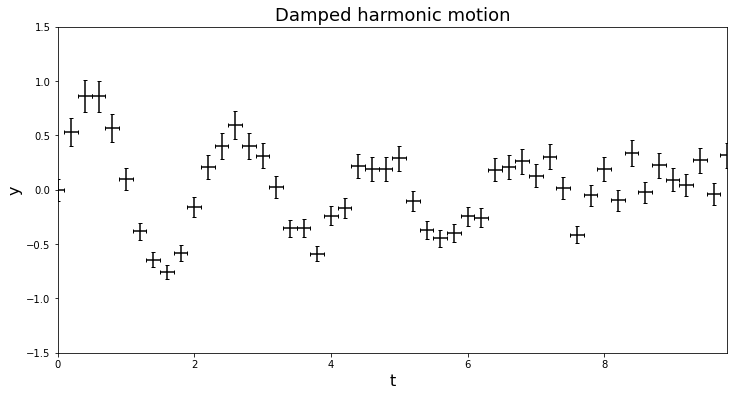

In [31]:
fig, axes = plt.subplots(1,1,figsize=(12,6)) #Creates a single figure with dimensions (12 by 6 (inch))
axes.errorbar(t,y,xerr=terr,yerr=yerr,fmt='none',ecolor='black',capsize=2) #fmt, ecolor and capsize can be personalized.
axes.set_title('Damped harmonic motion', fontsize=18)
axes.set_xlabel('t',fontsize=16)
axes.set_ylabel('y',fontsize=16)
axes.set_xlim(np.min(t),np.max(t))
axes.set_ylim(-1.5,1.5)
plt.show()

In [26]:

import warnings
# from . import _minpack

import numpy as np
from numpy import (atleast_1d, dot, take, triu, shape, eye,
                   transpose, zeros, prod, greater,
                   asarray, inf,
                   finfo, inexact, issubdtype, dtype)
from scipy.linalg import svd, cholesky, solve_triangular, LinAlgError, inv
from scipy._lib._util import _asarray_validated, _lazywhere
from scipy._lib._util import getfullargspec_no_self as _getfullargspec
# from ._optimize import OptimizeResult, _check_unknown_options, OptimizeWarning
# from ._lsq import least_squares
# from ._lsq.common import make_strictly_feasible
# from ._lsq.least_squares import prepare_bounds
# 
# error = _minpack.error

__all__ = ['fsolve', 'leastsq', 'fixed_point', 'curve_fit']


def _check_func(checker, argname, thefunc, x0, args, numinputs,
                output_shape=None):
    res = atleast_1d(thefunc(*((x0[:numinputs],) + args)))
    if (output_shape is not None) and (shape(res) != output_shape):
        if (output_shape[0] != 1):
            if len(output_shape) > 1:
                if output_shape[1] == 1:
                    return shape(res)
            msg = "%s: there is a mismatch between the input and output " \
                  "shape of the '%s' argument" % (checker, argname)
            func_name = getattr(thefunc, '__name__', None)
            if func_name:
                msg += " '%s'." % func_name
            else:
                msg += "."
            msg += 'Shape should be %s but it is %s.' % (output_shape, shape(res))
            raise TypeError(msg)
    if issubdtype(res.dtype, inexact):
        dt = res.dtype
    else:
        dt = dtype(float)
    return shape(res), dt


def fsolve(func, x0, args=(), fprime=None, full_output=0,
           col_deriv=0, xtol=1.49012e-8, maxfev=0, band=None,
           epsfcn=None, factor=100, diag=None):
    """
    Find the roots of a function.
    Return the roots of the (non-linear) equations defined by
    ``func(x) = 0`` given a starting estimate.
    Parameters
    ----------
    func : callable ``f(x, *args)``
        A function that takes at least one (possibly vector) argument,
        and returns a value of the same length.
    x0 : ndarray
        The starting estimate for the roots of ``func(x) = 0``.
    args : tuple, optional
        Any extra arguments to `func`.
    fprime : callable ``f(x, *args)``, optional
        A function to compute the Jacobian of `func` with derivatives
        across the rows. By default, the Jacobian will be estimated.
    full_output : bool, optional
        If True, return optional outputs.
    col_deriv : bool, optional
        Specify whether the Jacobian function computes derivatives down
        the columns (faster, because there is no transpose operation).
    xtol : float, optional
        The calculation will terminate if the relative error between two
        consecutive iterates is at most `xtol`.
    maxfev : int, optional
        The maximum number of calls to the function. If zero, then
        ``100*(N+1)`` is the maximum where N is the number of elements
        in `x0`.
    band : tuple, optional
        If set to a two-sequence containing the number of sub- and
        super-diagonals within the band of the Jacobi matrix, the
        Jacobi matrix is considered banded (only for ``fprime=None``).
    epsfcn : float, optional
        A suitable step length for the forward-difference
        approximation of the Jacobian (for ``fprime=None``). If
        `epsfcn` is less than the machine precision, it is assumed
        that the relative errors in the functions are of the order of
        the machine precision.
    factor : float, optional
        A parameter determining the initial step bound
        (``factor * || diag * x||``). Should be in the interval
        ``(0.1, 100)``.
    diag : sequence, optional
        N positive entries that serve as a scale factors for the
        variables.
    Returns
    -------
    x : ndarray
        The solution (or the result of the last iteration for
        an unsuccessful call).
    infodict : dict
        A dictionary of optional outputs with the keys:
        ``nfev``
            number of function calls
        ``njev``
            number of Jacobian calls
        ``fvec``
            function evaluated at the output
        ``fjac``
            the orthogonal matrix, q, produced by the QR
            factorization of the final approximate Jacobian
            matrix, stored column wise
        ``r``
            upper triangular matrix produced by QR factorization
            of the same matrix
        ``qtf``
            the vector ``(transpose(q) * fvec)``
    ier : int
        An integer flag.  Set to 1 if a solution was found, otherwise refer
        to `mesg` for more information.
    mesg : str
        If no solution is found, `mesg` details the cause of failure.
    See Also
    --------
    root : Interface to root finding algorithms for multivariate
           functions. See the ``method=='hybr'`` in particular.
    Notes
    -----
    ``fsolve`` is a wrapper around MINPACK's hybrd and hybrj algorithms.
    Examples
    --------
    Find a solution to the system of equations:
    ``x0*cos(x1) = 4,  x1*x0 - x1 = 5``.
    >>> from scipy.optimize import fsolve
    >>> def func(x):
    ...     return [x[0] * np.cos(x[1]) - 4,
    ...             x[1] * x[0] - x[1] - 5]
    >>> root = fsolve(func, [1, 1])
    >>> root
    array([6.50409711, 0.90841421])
    >>> np.isclose(func(root), [0.0, 0.0])  # func(root) should be almost 0.0.
    array([ True,  True])
    """
    options = {'col_deriv': col_deriv,
               'xtol': xtol,
               'maxfev': maxfev,
               'band': band,
               'eps': epsfcn,
               'factor': factor,
               'diag': diag}

    res = _root_hybr(func, x0, args, jac=fprime, **options)
    if full_output:
        x = res['x']
        info = dict((k, res.get(k))
                    for k in ('nfev', 'njev', 'fjac', 'r', 'qtf') if k in res)
        info['fvec'] = res['fun']
        return x, info, res['status'], res['message']
    else:
        status = res['status']
        msg = res['message']
        if status == 0:
            raise TypeError(msg)
        elif status == 1:
            pass
        elif status in [2, 3, 4, 5]:
            warnings.warn(msg, RuntimeWarning)
        else:
            raise TypeError(msg)
        return res['x']


def _root_hybr(func, x0, args=(), jac=None,
               col_deriv=0, xtol=1.49012e-08, maxfev=0, band=None, eps=None,
               factor=100, diag=None, **unknown_options):
    """
    Find the roots of a multivariate function using MINPACK's hybrd and
    hybrj routines (modified Powell method).
    Options
    -------
    col_deriv : bool
        Specify whether the Jacobian function computes derivatives down
        the columns (faster, because there is no transpose operation).
    xtol : float
        The calculation will terminate if the relative error between two
        consecutive iterates is at most `xtol`.
    maxfev : int
        The maximum number of calls to the function. If zero, then
        ``100*(N+1)`` is the maximum where N is the number of elements
        in `x0`.
    band : tuple
        If set to a two-sequence containing the number of sub- and
        super-diagonals within the band of the Jacobi matrix, the
        Jacobi matrix is considered banded (only for ``fprime=None``).
    eps : float
        A suitable step length for the forward-difference
        approximation of the Jacobian (for ``fprime=None``). If
        `eps` is less than the machine precision, it is assumed
        that the relative errors in the functions are of the order of
        the machine precision.
    factor : float
        A parameter determining the initial step bound
        (``factor * || diag * x||``). Should be in the interval
        ``(0.1, 100)``.
    diag : sequence
        N positive entries that serve as a scale factors for the
        variables.
    """
    _check_unknown_options(unknown_options)
    epsfcn = eps

    x0 = asarray(x0).flatten()
    n = len(x0)
    if not isinstance(args, tuple):
        args = (args,)
    shape, dtype = _check_func('fsolve', 'func', func, x0, args, n, (n,))
    if epsfcn is None:
        epsfcn = finfo(dtype).eps
    Dfun = jac
    if Dfun is None:
        if band is None:
            ml, mu = -10, -10
        else:
            ml, mu = band[:2]
        if maxfev == 0:
            maxfev = 200 * (n + 1)
        retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
                                 ml, mu, epsfcn, factor, diag)
    else:
        _check_func('fsolve', 'fprime', Dfun, x0, args, n, (n, n))
        if (maxfev == 0):
            maxfev = 100 * (n + 1)
        retval = _minpack._hybrj(func, Dfun, x0, args, 1,
                                 col_deriv, xtol, maxfev, factor, diag)

    x, status = retval[0], retval[-1]

    errors = {0: "Improper input parameters were entered.",
              1: "The solution converged.",
              2: "The number of calls to function has "
                  "reached maxfev = %d." % maxfev,
              3: "xtol=%f is too small, no further improvement "
                  "in the approximate\n  solution "
                  "is possible." % xtol,
              4: "The iteration is not making good progress, as measured "
                  "by the \n  improvement from the last five "
                  "Jacobian evaluations.",
              5: "The iteration is not making good progress, "
                  "as measured by the \n  improvement from the last "
                  "ten iterations.",
              'unknown': "An error occurred."}

    info = retval[1]
    info['fun'] = info.pop('fvec')
    sol = OptimizeResult(x=x, success=(status == 1), status=status)
    sol.update(info)
    try:
        sol['message'] = errors[status]
    except KeyError:
        sol['message'] = errors['unknown']

    return sol


LEASTSQ_SUCCESS = [1, 2, 3, 4]
LEASTSQ_FAILURE = [5, 6, 7, 8]


def leastsq(func, x0, args=(), Dfun=None, full_output=0,
            col_deriv=0, ftol=1.49012e-8, xtol=1.49012e-8,
            gtol=0.0, maxfev=0, epsfcn=None, factor=100, diag=None):
    """
    Minimize the sum of squares of a set of equations.
    ::
        x = arg min(sum(func(y)**2,axis=0))
                 y
    Parameters
    ----------
    func : callable
        Should take at least one (possibly length ``N`` vector) argument and
        returns ``M`` floating point numbers. It must not return NaNs or
        fitting might fail. ``M`` must be greater than or equal to ``N``.
    x0 : ndarray
        The starting estimate for the minimization.
    args : tuple, optional
        Any extra arguments to func are placed in this tuple.
    Dfun : callable, optional
        A function or method to compute the Jacobian of func with derivatives
        across the rows. If this is None, the Jacobian will be estimated.
    full_output : bool, optional
        non-zero to return all optional outputs.
    col_deriv : bool, optional
        non-zero to specify that the Jacobian function computes derivatives
        down the columns (faster, because there is no transpose operation).
    ftol : float, optional
        Relative error desired in the sum of squares.
    xtol : float, optional
        Relative error desired in the approximate solution.
    gtol : float, optional
        Orthogonality desired between the function vector and the columns of
        the Jacobian.
    maxfev : int, optional
        The maximum number of calls to the function. If `Dfun` is provided,
        then the default `maxfev` is 100*(N+1) where N is the number of elements
        in x0, otherwise the default `maxfev` is 200*(N+1).
    epsfcn : float, optional
        A variable used in determining a suitable step length for the forward-
        difference approximation of the Jacobian (for Dfun=None).
        Normally the actual step length will be sqrt(epsfcn)*x
        If epsfcn is less than the machine precision, it is assumed that the
        relative errors are of the order of the machine precision.
    factor : float, optional
        A parameter determining the initial step bound
        (``factor * || diag * x||``). Should be in interval ``(0.1, 100)``.
    diag : sequence, optional
        N positive entries that serve as a scale factors for the variables.
    Returns
    -------
    x : ndarray
        The solution (or the result of the last iteration for an unsuccessful
        call).
    cov_x : ndarray
        The inverse of the Hessian. `fjac` and `ipvt` are used to construct an
        estimate of the Hessian. A value of None indicates a singular matrix,
        which means the curvature in parameters `x` is numerically flat. To
        obtain the covariance matrix of the parameters `x`, `cov_x` must be
        multiplied by the variance of the residuals -- see curve_fit.
    infodict : dict
        a dictionary of optional outputs with the keys:
        ``nfev``
            The number of function calls
        ``fvec``
            The function evaluated at the output
        ``fjac``
            A permutation of the R matrix of a QR
            factorization of the final approximate
            Jacobian matrix, stored column wise.
            Together with ipvt, the covariance of the
            estimate can be approximated.
        ``ipvt``
            An integer array of length N which defines
            a permutation matrix, p, such that
            fjac*p = q*r, where r is upper triangular
            with diagonal elements of nonincreasing
            magnitude. Column j of p is column ipvt(j)
            of the identity matrix.
        ``qtf``
            The vector (transpose(q) * fvec).
    mesg : str
        A string message giving information about the cause of failure.
    ier : int
        An integer flag. If it is equal to 1, 2, 3 or 4, the solution was
        found. Otherwise, the solution was not found. In either case, the
        optional output variable 'mesg' gives more information.
    See Also
    --------
    least_squares : Newer interface to solve nonlinear least-squares problems
        with bounds on the variables. See ``method=='lm'`` in particular.
    Notes
    -----
    "leastsq" is a wrapper around MINPACK's lmdif and lmder algorithms.
    cov_x is a Jacobian approximation to the Hessian of the least squares
    objective function.
    This approximation assumes that the objective function is based on the
    difference between some observed target data (ydata) and a (non-linear)
    function of the parameters `f(xdata, params)` ::
           func(params) = ydata - f(xdata, params)
    so that the objective function is ::
           min   sum((ydata - f(xdata, params))**2, axis=0)
         params
    The solution, `x`, is always a 1-D array, regardless of the shape of `x0`,
    or whether `x0` is a scalar.
    Examples
    --------
    >>> from scipy.optimize import leastsq
    >>> def func(x):
    ...     return 2*(x-3)**2+1
    >>> leastsq(func, 0)
    (array([2.99999999]), 1)
    """
    x0 = asarray(x0).flatten()
    n = len(x0)
    if not isinstance(args, tuple):
        args = (args,)
    shape, dtype = _check_func('leastsq', 'func', func, x0, args, n)
    m = shape[0]

    if n > m:
        raise TypeError(f"Improper input: func input vector length N={n} must"
                        f" not exceed func output vector length M={m}")

    if epsfcn is None:
        epsfcn = finfo(dtype).eps

    # if Dfun is None:
    #     if maxfev == 0:
    #         maxfev = 200*(n + 1)
    #     retval = _minpack._lmdif(func, x0, args, full_output, ftol, xtol,
    #                              gtol, maxfev, epsfcn, factor, diag)
    else:
        if col_deriv:
            _check_func('leastsq', 'Dfun', Dfun, x0, args, n, (n, m))
        else:
            _check_func('leastsq', 'Dfun', Dfun, x0, args, n, (m, n))
        # if maxfev == 0:
        #     maxfev = 100 * (n + 1)
        # retval = _minpack._lmder(func, Dfun, x0, args, full_output,
        #                          col_deriv, ftol, xtol, gtol, maxfev,
        #                          factor, diag)

    errors = {0: ["Improper input parameters.", TypeError],
              1: ["Both actual and predicted relative reductions "
                  "in the sum of squares\n  are at most %f" % ftol, None],
              2: ["The relative error between two consecutive "
                  "iterates is at most %f" % xtol, None],
              3: ["Both actual and predicted relative reductions in "
                  "the sum of squares\n  are at most %f and the "
                  "relative error between two consecutive "
                  "iterates is at \n  most %f" % (ftol, xtol), None],
              4: ["The cosine of the angle between func(x) and any "
                  "column of the\n  Jacobian is at most %f in "
                  "absolute value" % gtol, None],
              5: ["Number of calls to function has reached "
                  "maxfev = %d." % maxfev, ValueError],
              6: ["ftol=%f is too small, no further reduction "
                  "in the sum of squares\n  is possible." % ftol,
                  ValueError],
              7: ["xtol=%f is too small, no further improvement in "
                  "the approximate\n  solution is possible." % xtol,
                  ValueError],
              8: ["gtol=%f is too small, func(x) is orthogonal to the "
                  "columns of\n  the Jacobian to machine "
                  "precision." % gtol, ValueError]}

    # The FORTRAN return value (possible return values are >= 0 and <= 8)
    # info = retval[-1]

    if full_output:
        cov_x = None
        if info in LEASTSQ_SUCCESS:
            perm = take(eye(n), retval[1]['ipvt'] - 1, 0)
            r = triu(transpose(retval[1]['fjac'])[:n, :])
            R = dot(r, perm)
            try:
                cov_x = inv(dot(transpose(R), R))
            except (LinAlgError, ValueError):
                pass
        return (retval[0], cov_x) + retval[1:-1] + (errors[info][0], info)
    else:
        # if info in LEASTSQ_FAILURE:
        #     warnings.warn(errors[info][0], RuntimeWarning)
        # elif info == 0:
        #     raise errors[info][1](errors[info][0])
        # return retval[0], info


def _wrap_func(func, xdata, ydata, transform):
    if transform is None:
        def func_wrapped(params):
            return func(xdata, *params) - ydata
    elif transform.ndim == 1:
        def func_wrapped(params):
            return transform * (func(xdata, *params) - ydata)
    else:
        # Chisq = (y - yd)^T C^{-1} (y-yd)
        # transform = L such that C = L L^T
        # C^{-1} = L^{-T} L^{-1}
        # Chisq = (y - yd)^T L^{-T} L^{-1} (y-yd)
        # Define (y-yd)' = L^{-1} (y-yd)
        # by solving
        # L (y-yd)' = (y-yd)
        # and minimize (y-yd)'^T (y-yd)'
        def func_wrapped(params):
            return solve_triangular(transform, func(xdata, *params) - ydata, lower=True)
    return func_wrapped


def _wrap_jac(jac, xdata, transform):
    if transform is None:
        def jac_wrapped(params):
            return jac(xdata, *params)
    elif transform.ndim == 1:
        def jac_wrapped(params):
            return transform[:, np.newaxis] * np.asarray(jac(xdata, *params))
    else:
        def jac_wrapped(params):
            return solve_triangular(transform, np.asarray(jac(xdata, *params)), lower=True)
    return jac_wrapped


def _initialize_feasible(lb, ub):
    p0 = np.ones_like(lb)
    lb_finite = np.isfinite(lb)
    ub_finite = np.isfinite(ub)

    mask = lb_finite & ub_finite
    p0[mask] = 0.5 * (lb[mask] + ub[mask])

    mask = lb_finite & ~ub_finite
    p0[mask] = lb[mask] + 1

    mask = ~lb_finite & ub_finite
    p0[mask] = ub[mask] - 1

    return p0


def curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False,
              check_finite=True, bounds=(-np.inf, np.inf), method=None,
              jac=None, *, full_output=False, **kwargs):
    """
    Use non-linear least squares to fit a function, f, to data.
    Assumes ``ydata = f(xdata, *params) + eps``.
    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N). If None, then the
        initial values will all be 1 (if the number of parameters for the
        function can be determined using introspection, otherwise a
        ValueError is raised).
    sigma : None or M-length sequence or MxM array, optional
        Determines the uncertainty in `ydata`. If we define residuals as
        ``r = ydata - f(xdata, *popt)``, then the interpretation of `sigma`
        depends on its number of dimensions:
            - A 1-D `sigma` should contain values of standard deviations of
              errors in `ydata`. In this case, the optimized function is
              ``chisq = sum((r / sigma) ** 2)``.
            - A 2-D `sigma` should contain the covariance matrix of
              errors in `ydata`. In this case, the optimized function is
              ``chisq = r.T @ inv(sigma) @ r``.
              .. versionadded:: 0.19
        None (default) is equivalent of 1-D `sigma` filled with ones.
    absolute_sigma : bool, optional
        If True, `sigma` is used in an absolute sense and the estimated parameter
        covariance `pcov` reflects these absolute values.
        If False (default), only the relative magnitudes of the `sigma` values matter.
        The returned parameter covariance matrix `pcov` is based on scaling
        `sigma` by a constant factor. This constant is set by demanding that the
        reduced `chisq` for the optimal parameters `popt` when using the
        *scaled* `sigma` equals unity. In other words, `sigma` is scaled to
        match the sample variance of the residuals after the fit. Default is False.
        Mathematically,
        ``pcov(absolute_sigma=False) = pcov(absolute_sigma=True) * chisq(popt)/(M-N)``
    check_finite : bool, optional
        If True, check that the input arrays do not contain nans of infs,
        and raise a ValueError if they do. Setting this parameter to
        False may silently produce nonsensical results if the input arrays
        do contain nans. Default is True.
    bounds : 2-tuple of array_like, optional
        Lower and upper bounds on parameters. Defaults to no bounds.
        Each element of the tuple must be either an array with the length equal
        to the number of parameters, or a scalar (in which case the bound is
        taken to be the same for all parameters). Use ``np.inf`` with an
        appropriate sign to disable bounds on all or some parameters.
        .. versionadded:: 0.17
    method : {'lm', 'trf', 'dogbox'}, optional
        Method to use for optimization. See `least_squares` for more details.
        Default is 'lm' for unconstrained problems and 'trf' if `bounds` are
        provided. The method 'lm' won't work when the number of observations
        is less than the number of variables, use 'trf' or 'dogbox' in this
        case.
        .. versionadded:: 0.17
    jac : callable, string or None, optional
        Function with signature ``jac(x, ...)`` which computes the Jacobian
        matrix of the model function with respect to parameters as a dense
        array_like structure. It will be scaled according to provided `sigma`.
        If None (default), the Jacobian will be estimated numerically.
        String keywords for 'trf' and 'dogbox' methods can be used to select
        a finite difference scheme, see `least_squares`.
        .. versionadded:: 0.18
    full_output : boolean, optional
        If True, this function returns additioal information: `infodict`,
        `mesg`, and `ier`.
        .. versionadded:: 1.9
    **kwargs
        Keyword arguments passed to `leastsq` for ``method='lm'`` or
        `least_squares` otherwise.
    Returns
    -------
    popt : array
        Optimal values for the parameters so that the sum of the squared
        residuals of ``f(xdata, *popt) - ydata`` is minimized.
    pcov : 2-D array
        The estimated covariance of popt. The diagonals provide the variance
        of the parameter estimate. To compute one standard deviation errors
        on the parameters use ``perr = np.sqrt(np.diag(pcov))``.
        How the `sigma` parameter affects the estimated covariance
        depends on `absolute_sigma` argument, as described above.
        If the Jacobian matrix at the solution doesn't have a full rank, then
        'lm' method returns a matrix filled with ``np.inf``, on the other hand
        'trf'  and 'dogbox' methods use Moore-Penrose pseudoinverse to compute
        the covariance matrix.
    infodict : dict (returned only if `full_output` is True)
        a dictionary of optional outputs with the keys:
        ``nfev``
            The number of function calls. Methods 'trf' and 'dogbox' do not
            count function calls for numerical Jacobian approximation,
            as opposed to 'lm' method.
        ``fvec``
            The function values evaluated at the solution.
        ``fjac``
            A permutation of the R matrix of a QR
            factorization of the final approximate
            Jacobian matrix, stored column wise.
            Together with ipvt, the covariance of the
            estimate can be approximated.
            Method 'lm' only provides this information.
        ``ipvt``
            An integer array of length N which defines
            a permutation matrix, p, such that
            fjac*p = q*r, where r is upper triangular
            with diagonal elements of nonincreasing
            magnitude. Column j of p is column ipvt(j)
            of the identity matrix.
            Method 'lm' only provides this information.
        ``qtf``
            The vector (transpose(q) * fvec).
            Method 'lm' only provides this information.
        .. versionadded:: 1.9
    mesg : str (returned only if `full_output` is True)
        A string message giving information about the solution.
        .. versionadded:: 1.9
    ier : int (returnned only if `full_output` is True)
        An integer flag. If it is equal to 1, 2, 3 or 4, the solution was
        found. Otherwise, the solution was not found. In either case, the
        optional output variable `mesg` gives more information.
        .. versionadded:: 1.9
    Raises
    ------
    ValueError
        if either `ydata` or `xdata` contain NaNs, or if incompatible options
        are used.
    RuntimeError
        if the least-squares minimization fails.
    OptimizeWarning
        if covariance of the parameters can not be estimated.
    See Also
    --------
    least_squares : Minimize the sum of squares of nonlinear functions.
    scipy.stats.linregress : Calculate a linear least squares regression for
                             two sets of measurements.
    Notes
    -----
    Users should ensure that inputs `xdata`, `ydata`, and the output of `f`
    are ``float64``, or else the optimization may return incorrect results.
    
    With ``method='lm'``, the algorithm uses the Levenberg-Marquardt algorithm
    through `leastsq`. Note that this algorithm can only deal with
    unconstrained problems.
    Box constraints can be handled by methods 'trf' and 'dogbox'. Refer to
    the docstring of `least_squares` for more information.
    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> from scipy.optimize import curve_fit
    >>> def func(x, a, b, c):
    ...     return a * np.exp(-b * x) + c
    Define the data to be fit with some noise:
    >>> xdata = np.linspace(0, 4, 50)
    >>> y = func(xdata, 2.5, 1.3, 0.5)
    >>> rng = np.random.default_rng()
    >>> y_noise = 0.2 * rng.normal(size=xdata.size)
    >>> ydata = y + y_noise
    >>> plt.plot(xdata, ydata, 'b-', label='data')
    Fit for the parameters a, b, c of the function `func`:
    >>> popt, pcov = curve_fit(func, xdata, ydata)
    >>> popt
    array([2.56274217, 1.37268521, 0.47427475])
    >>> plt.plot(xdata, func(xdata, *popt), 'r-',
    ...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    Constrain the optimization to the region of ``0 <= a <= 3``,
    ``0 <= b <= 1`` and ``0 <= c <= 0.5``:
    >>> popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
    >>> popt
    array([2.43736712, 1.        , 0.34463856])
    >>> plt.plot(xdata, func(xdata, *popt), 'g--',
    ...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    >>> plt.xlabel('x')
    >>> plt.ylabel('y')
    >>> plt.legend()
    >>> plt.show()
    """
    if p0 is None:
        # determine number of parameters by inspecting the function
        sig = _getfullargspec(f)
        args = sig.args
        if len(args) < 2:
            raise ValueError("Unable to determine number of fit parameters.")
        n = len(args) - 1
    else:
        p0 = np.atleast_1d(p0)
        n = p0.size

    lb, ub = prepare_bounds(bounds, n)
    if p0 is None:
        p0 = _initialize_feasible(lb, ub)

    bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
    if method is None:
        if bounded_problem:
            method = 'trf'
        else:
            method = 'lm'

    if method == 'lm' and bounded_problem:
        raise ValueError("Method 'lm' only works for unconstrained problems. "
                         "Use 'trf' or 'dogbox' instead.")

    # optimization may produce garbage for float32 inputs, cast them to float64

    # NaNs cannot be handled
    if check_finite:
        ydata = np.asarray_chkfinite(ydata, float)
    else:
        ydata = np.asarray(ydata, float)

    if isinstance(xdata, (list, tuple, np.ndarray)):
        # `xdata` is passed straight to the user-defined `f`, so allow
        # non-array_like `xdata`.
        if check_finite:
            xdata = np.asarray_chkfinite(xdata, float)
        else:
            xdata = np.asarray(xdata, float)

    if ydata.size == 0:
        raise ValueError("`ydata` must not be empty!")

    # Determine type of sigma
    if sigma is not None:
        sigma = np.asarray(sigma)

        # if 1-D, sigma are errors, define transform = 1/sigma
        if sigma.shape == (ydata.size, ):
            transform = 1.0 / sigma
        # if 2-D, sigma is the covariance matrix,
        # define transform = L such that L L^T = C
        elif sigma.shape == (ydata.size, ydata.size):
            try:
                # scipy.linalg.cholesky requires lower=True to return L L^T = A
                transform = cholesky(sigma, lower=True)
            except LinAlgError as e:
                raise ValueError("`sigma` must be positive definite.") from e
        else:
            raise ValueError("`sigma` has incorrect shape.")
    else:
        transform = None

    func = _wrap_func(f, xdata, ydata, transform)
    if callable(jac):
        jac = _wrap_jac(jac, xdata, transform)
    elif jac is None and method != 'lm':
        jac = '2-point'

    if 'args' in kwargs:
        # The specification for the model function `f` does not support
        # additional arguments. Refer to the `curve_fit` docstring for
        # acceptable call signatures of `f`.
        raise ValueError("'args' is not a supported keyword argument.")

    if method == 'lm':
        # if ydata.size == 1, this might be used for broadcast.
        if ydata.size != 1 and n > ydata.size:
            raise TypeError(f"The number of func parameters={n} must not"
                            f" exceed the number of data points={ydata.size}")
        res = leastsq(func, p0, Dfun=jac, full_output=1, **kwargs)
        popt, pcov, infodict, errmsg, ier = res
        ysize = len(infodict['fvec'])
        cost = np.sum(infodict['fvec'] ** 2)
        if ier not in [1, 2, 3, 4]:
            raise RuntimeError("Optimal parameters not found: " + errmsg)
    else:
        # Rename maxfev (leastsq) to max_nfev (least_squares), if specified.
        if 'max_nfev' not in kwargs:
            kwargs['max_nfev'] = kwargs.pop('maxfev', None)

        res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
                            **kwargs)

        if not res.success:
            raise RuntimeError("Optimal parameters not found: " + res.message)

        infodict = dict(nfev=res.nfev, fvec=res.fun)
        ier = res.status
        errmsg = res.message

        ysize = len(res.fun)
        cost = 2 * res.cost  # res.cost is half sum of squares!
        popt = res.x

        # Do Moore-Penrose inverse discarding zero singular values.
        _, s, VT = svd(res.jac, full_matrices=False)
        threshold = np.finfo(float).eps * max(res.jac.shape) * s[0]
        s = s[s > threshold]
        VT = VT[:s.size]
        pcov = np.dot(VT.T / s**2, VT)

    warn_cov = False
    if pcov is None:
        # indeterminate covariance
        pcov = zeros((len(popt), len(popt)), dtype=float)
        pcov.fill(inf)
        warn_cov = True
    elif not absolute_sigma:
        if ysize > p0.size:
            s_sq = cost / (ysize - p0.size)
            pcov = pcov * s_sq
        else:
            pcov.fill(inf)
            warn_cov = True

    if warn_cov:
        warnings.warn('Covariance of the parameters could not be estimated',
                      category=OptimizeWarning)

    if full_output:
        return popt, pcov, infodict, errmsg, ier
    else:
        return popt, pcov


def check_gradient(fcn, Dfcn, x0, args=(), col_deriv=0):
    """Perform a simple check on the gradient for correctness.
    """

    x = atleast_1d(x0)
    n = len(x)
    x = x.reshape((n,))
    fvec = atleast_1d(fcn(x, *args))
    m = len(fvec)
    fvec = fvec.reshape((m,))
    ldfjac = m
    fjac = atleast_1d(Dfcn(x, *args))
    fjac = fjac.reshape((m, n))
    if col_deriv == 0:
        fjac = transpose(fjac)

    xp = zeros((n,), float)
    err = zeros((m,), float)
    fvecp = None
    _minpack._chkder(m, n, x, fvec, fjac, ldfjac, xp, fvecp, 1, err)

    fvecp = atleast_1d(fcn(xp, *args))
    fvecp = fvecp.reshape((m,))
    _minpack._chkder(m, n, x, fvec, fjac, ldfjac, xp, fvecp, 2, err)

    good = (prod(greater(err, 0.5), axis=0))

    return (good, err)


def _del2(p0, p1, d):
    return p0 - np.square(p1 - p0) / d


def _relerr(actual, desired):
    return (actual - desired) / desired


def _fixed_point_helper(func, x0, args, xtol, maxiter, use_accel):
    p0 = x0
    for i in range(maxiter):
        p1 = func(p0, *args)
        if use_accel:
            p2 = func(p1, *args)
            d = p2 - 2.0 * p1 + p0
            p = _lazywhere(d != 0, (p0, p1, d), f=_del2, fillvalue=p2)
        else:
            p = p1
        relerr = _lazywhere(p0 != 0, (p, p0), f=_relerr, fillvalue=p)
        if np.all(np.abs(relerr) < xtol):
            return p
        p0 = p
    msg = "Failed to converge after %d iterations, value is %s" % (maxiter, p)
    raise RuntimeError(msg)


def fixed_point(func, x0, args=(), xtol=1e-8, maxiter=500, method='del2'):
    """
    Find a fixed point of the function.
    Given a function of one or more variables and a starting point, find a
    fixed point of the function: i.e., where ``func(x0) == x0``.
    Parameters
    ----------
    func : function
        Function to evaluate.
    x0 : array_like
        Fixed point of function.
    args : tuple, optional
        Extra arguments to `func`.
    xtol : float, optional
        Convergence tolerance, defaults to 1e-08.
    maxiter : int, optional
        Maximum number of iterations, defaults to 500.
    method : {"del2", "iteration"}, optional
        Method of finding the fixed-point, defaults to "del2",
        which uses Steffensen's Method with Aitken's ``Del^2``
        convergence acceleration [1]_. The "iteration" method simply iterates
        the function until convergence is detected, without attempting to
        accelerate the convergence.
    References
    ----------
    .. [1] Burden, Faires, "Numerical Analysis", 5th edition, pg. 80
    Examples
    --------
    >>> from scipy import optimize
    >>> def func(x, c1, c2):
    ...    return np.sqrt(c1/(x+c2))
    >>> c1 = np.array([10,12.])
    >>> c2 = np.array([3, 5.])
    >>> optimize.fixed_point(func, [1.2, 1.3], args=(c1,c2))
    array([ 1.4920333 ,  1.37228132])
    """
    use_accel = {'del2': True, 'iteration': False}[method]
    x0 = _asarray_validated(x0, as_inexact=True)
    return _fixed_point_helper(func, x0, args, xtol, maxiter, use_accel)

IndentationError: expected an indented block (419512821.py, line 455)

In [28]:
def func(x):
    return np.cos(x)

leastsq(func, 0)

NameError: name 'info' is not defined